## Goal of the notebook

The scores for classical ML methods are quite low at around 65%. This is because these methods
are not accounting for the context in the text. So using a method which takes into account the
context would likely give better accuracy scores. So I will try to implement a basic BERT model in this notebook.

About BERT:

> BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. 

We are basically using transfer learning for a specific task of sarcasm detection.

## How BERT works?

> *As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).*



![BERTexplained](../images/BERTexplained.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np 

from sklearn.model_selection import train_test_split  

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow_text as text 

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, 
                            classification_report,ConfusionMatrixDisplay,
                            plot_confusion_matrix)


In [2]:
np.random.seed(73)#to maintain reproducibility

In [3]:
df =pd.read_json('../data/Sarcasm_Headlines_Dataset.json',lines=True)#using original dataset as BERT has preprocessing abilities
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
X = df['headline']#creating X and y variables
y = df['is_sarcastic']


## Train Test Split

In [5]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,)
X_train.head()

14075    tight wisconsin house primary too close to cal...
6861     labor dept. creates 20,000 new hobbies for nat...
20106    fired u.s. attorney preet bharara said to have...
8679     bosnian gum company introduces new war-flavore...
24542    adele sends her love to brussels with touching...
Name: headline, dtype: object

## BERT Model

In [6]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-07-18 15:18:00.895287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

### Compilation

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # only using accuracy metric here
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size = 32) # for 5 epochs, can be increased

Epoch 1/5
668/668 [==============================] - 11964s 18s/step - loss: 0.5328 - accuracy: 0.7457 - val_loss: 0.4920 - val_accuracy: 0.7757
Epoch 2/5
668/668 [==============================] - 4521s 7s/step - loss: 0.5048 - accuracy: 0.7608 - val_loss: 0.4908 - val_accuracy: 0.7864
Epoch 3/5
668/668 [==============================] - 8083s 12s/step - loss: 0.4908 - accuracy: 0.7697 - val_loss: 0.4712 - val_accuracy: 0.7694
Epoch 4/5
668/668 [==============================] - 4444s 7s/step - loss: 0.4801 - accuracy: 0.7747 - val_loss: 0.4517 - val_accuracy: 0.8063
Epoch 5/5
668/668 [==============================] - 13271s 20s/step - loss: 0.4742 - accuracy: 0.7809 - val_loss: 0.4455 - val_accuracy: 0.7986


In [14]:
#prediction for test data
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted[:5])

167/167 [==============================] - 901s 5s/step
[0.21912287 0.03539722 0.22227512 0.11817431 0.22190623]


In [16]:
#threshold
t = .5
# if a value is greater than or equal to 0.5 then it's a 1 else 0
y_predicted = [1 if x>=t else 0 for x in y_predicted]

### Model Summary

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [25]:
plt.plot(model.history.history['loss'], label='Train loss') 
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.legend();

KeyError: 'loss'

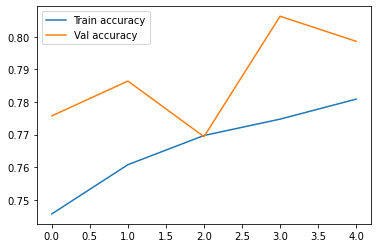

In [13]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

**Obervations:**
    
- **Val accuracy is always larger than train accuracy, the two graphs
intersect at epochs=2, so that would be like the most optimum number
of epochs**
- **However, the best test accuracy is achieved at epoch=3.**
- **Regularization mechanisms, such as Dropout and L1/L2 weight
regularization, are turned off at testing time. They are reflected in
the training time loss but not in the test time loss. Also, the
testing loss for an epoch is computed using the model as it is at the
end of the epoch, resulting in a lower loss.So the trends in graphs
here.**



### Confusion Matrix

Confusion Matrix: 

[[2585  412]
 [ 664 1681]]


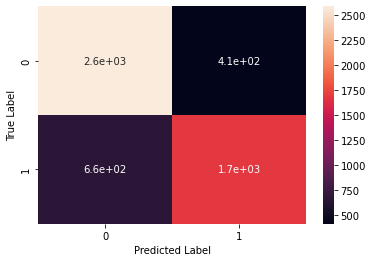

In [17]:
matrix = confusion_matrix(y_test, y_predicted)
print('Confusion Matrix: \n')
print(matrix)
# Convert to a pandas dataframe
confusion_df = pd.DataFrame(matrix, index=['0','1'], columns=['0','1'])

# Set the names of the x and y axis, this helps with the readability of the heatmap.
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'
sns.heatmap(confusion_df, annot=True);

### Accuracy

In [18]:
acc = accuracy_score(y_test, y_predicted)
print('accuracy:')
print(round(acc,2))

accuracy:
0.8


### Precision

In [19]:
precision = precision_score(y_test, y_predicted)
print('Precision score:')
print(round(precision,2))

Precision score:
0.8


### Recall

In [20]:
recall = recall_score(y_test, y_predicted)
print('Recall score:')
print(round(recall,2))

Recall score:
0.72


### Classification Report

In [21]:
print('Classification Report:')
print(classification_report(y_test, y_predicted))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2997
           1       0.80      0.72      0.76      2345

    accuracy                           0.80      5342
   macro avg       0.80      0.79      0.79      5342
weighted avg       0.80      0.80      0.80      5342



**Result:**

- **For 5 epochs accuracy is 80% which is 24% higher than baseline  and also significantly greater than the accuracy scores produced by classical ML methods.**
- **Precision in predicting both classes 0 and 1 respectively is 80%.**

**Reference**:

- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss
- https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270    
- https://www.analyticsvidhya.com/blog/2021/12/text-classification-using-bert-and-tensorflow/ 
- https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d